In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import re
import PIL
#from PIL import image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
landmarks_frame = pd.read_csv('/home/mumbot/tombs/smtesttomb/textblocks/dataprac.csv',  on_bad_lines='skip')

n = 65
img_name = landmarks_frame.iloc[n, 0]
#landmarks = landmarks_frame.iloc[n, 1:]
#landmarks = np.asarray(landmarks)
#landmarks = landmarks.astype('float').reshape(-1, 2)


landmarks = landmarks_frame.iloc[n, 5]
landmarks = landmarks.split(':')
landmarksx = landmarks[2]
m = re.search(r"\[([A-Za-z0-9_,]+)\]", landmarksx)
landmarksx = (m.group(1))
landmarksx = landmarksx.split(',')
landmarksy = landmarks[3]
m2 = re.search(r"\[([A-Za-z0-9_,]+)\]", landmarksy)
landmarksy = m2.group(1)
landmarksy = landmarksy.split(',')
landmarks = list(zip(landmarksx, landmarksy))
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float')


print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: fol.78_2R.jpg
Landmarks shape: (18, 2)
First 4 Landmarks: [[ 539. 3111.]
 [2085. 3099.]
 [2113. 2452.]
 [2097.  755.]]


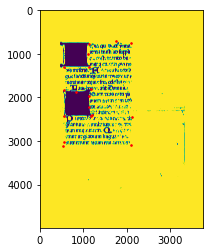

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('/home/mumbot/tombs/smtesttomb/textblocks/', img_name)),
               landmarks)
plt.show()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file, on_bad_lines='skip')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        #image = image.convert("RGB")
        
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        
        landmarks = self.landmarks_frame.iloc[idx, 5]
        landmarks = landmarks.split(':')
        landmarksx = landmarks[2]
        m = re.search(r"\[([A-Za-z0-9_,]+)\]", landmarksx)
        landmarksx = (m.group(1))
        landmarksx = landmarksx.split(',')
        landmarksy = landmarks[3]
        m2 = re.search(r"\[([A-Za-z0-9_,]+)\]", landmarksy)
        landmarksy = m2.group(1)
        landmarksy = landmarksy.split(',')
        landmarks = list(zip(landmarksx, landmarksy))
        landmarks = np.array([landmarks])    ################ mayb switch to tensor
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (4992, 3744) (18, 2)


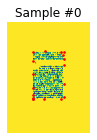

1 (4992, 3744) (17, 2)


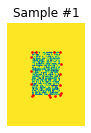

2 (4992, 3744) (19, 2)


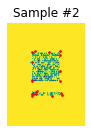

3 (4992, 3744) (20, 2)


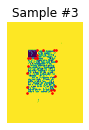

In [5]:
face_dataset = FaceLandmarksDataset(csv_file='/home/mumbot/tombs/smtesttomb/textblocks/dataprac.csv',
                                    root_dir='/home/mumbot/tombs/smtesttomb/textblocks/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [6]:
# add gag blur transformer, random solarize, random adjust sharpness, random autocontrast, color jitter, random grayscale, fivecrop


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
####   In the example above, RandomCrop uses an external library’s random number generator (in this case, Numpy’s np.random.int). This can result in unexpected behavior with DataLoader (see https://pytorch.org/docs/stable/notes/faq.html#my-data-loader-workers-return-identical-random-numbers). In practice, it is safer to stick to PyTorch’s random number generator, e.g. by using torch.randint instead.
        
        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

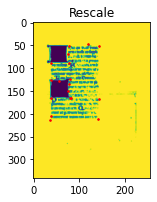

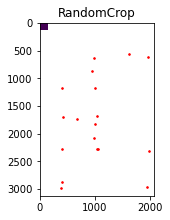

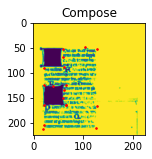

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [11]:
transformed_dataset = FaceLandmarksDataset(csv_file='/home/mumbot/tombs/smtesttomb/textblocks/dataprac.csv',
                                           root_dir='/home/mumbot/tombs/smtesttomb/textblocks/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([224, 224]) torch.Size([18, 2])
1 torch.Size([224, 224]) torch.Size([17, 2])
2 torch.Size([224, 224]) torch.Size([19, 2])
3 torch.Size([224, 224]) torch.Size([20, 2])


In [ ]:
# make collate_fn so that collate_fn = collate_longest
# aka allows for datasets with diff variable lengths and 
# allows for custom datasets

def collate_batch(batch):
    

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size=4, collate_fn=collate_batch
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

RuntimeError: stack expects each tensor to be equal size, but got [18, 2] at entry 0 and [10, 2] at entry 1